In [83]:
import rioxarray as rxr
import rasterio as rio
import geopandas as gpd
import xarray as xr
from geocube.api.core import make_geocube

In [84]:
carbon = rxr.open_rasterio('data/carbon_2022-11-01.tif')

In [85]:
carbon

<xarray.DataArray (band: 1, y: 1208, x: 1572)>
[1898976 values with dtype=int16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 3.754e+05 3.754e+05 ... 4.005e+05 4.005e+05
  * y            (y) float64 6.698e+06 6.698e+06 ... 6.679e+06 6.679e+06
    spatial_ref  int64 0
Attributes:
    LAYER_TYPE:              athematic
    STATISTICS_MAXIMUM:      32767
    STATISTICS_MEAN:         20684.194769859
    STATISTICS_MEDIAN:       0
    STATISTICS_MINIMUM:      0
    STATISTICS_MODE:         0
    STATISTICS_SKIPFACTORX:  12
    STATISTICS_SKIPFACTORY:  12
    STATISTICS_STDDEV:       13591.793066913
    scale_factor:            1.0
    add_offset:              0.0
    long_name:               Layer_1

In [86]:
# no data is 32766, non-forest is 32767
carbon = carbon.where(carbon < 32766)

In [87]:
# unit is 10 kg c / ha
# convert to kg / grid cell, where cell size is 16x16

ha_to_grid = 16 * 16 / 10000
grid_to_ha = 1 / ha_to_grid


In [88]:
carbon = carbon * ha_to_grid

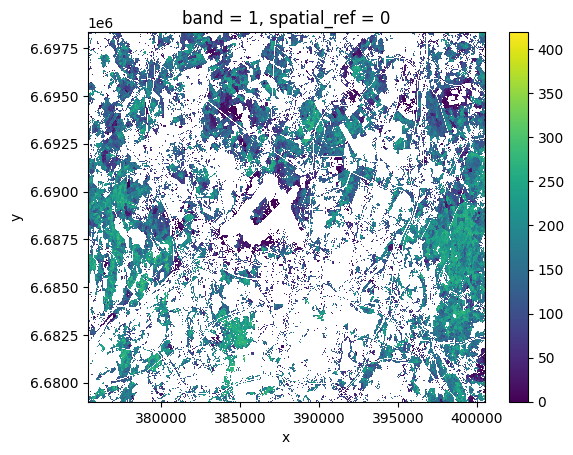

In [89]:
carbon.plot()

In [90]:
zone = gpd.read_file('data/vantaa_yk.shp')

In [91]:
zone.head()

,id,geom_type,kt,merkinta,yleiskaava,priority,taso,geometry
0,99,area,KM,KM - Kaupallisten palvelujen alue,Yleiskaava 2007,4,ktalue,"POLYGON ((25489760.098 6684987.869, 25489832.2..."
1,95,area,SL,SL - Luonnonsuojelualue,Yleiskaava 2007,4,ktalue,"POLYGON ((25494897.674 6690792.060, 25495007.4..."
2,97,area,T,T - Teollisuus- ja varastoalue,Yleiskaava 2007,4,ktalue,"POLYGON ((25490703.545 6685562.772, 25490715.2..."
3,75,area,VL,VL - Lähivirkistysalue,Yleiskaava 2007,4,ktalue,"POLYGON ((25492968.537 6684590.761, 25493046.5..."
4,77,area,KM,KM - Kaupallisten palvelujen alue,Yleiskaava 2007,4,ktalue,"POLYGON ((25489579.038 6685037.099, 25489645.1..."


In [92]:
zone["merkinta"].unique()

array(['KM - Kaupallisten palvelujen alue', 'SL - Luonnonsuojelualue',
       'T - Teollisuus- ja varastoalue', 'VL - Lähivirkistysalue',
       'A4 - Pientaloalue', 'C - Keskustatoimintojen alue',
       'A3 - Pientaloalue', 'TP - Työpaikka-alue', 'P1 - Palvelujen alue',
       'P2 - Palvelujen alue',
       'VU - Urheilu- ja virkistyspalvelujen alue',
       'ET - Yhdyskuntateknisen huollon alue', 'W - Vesialue',
       'AT - Kyläalue', 'A1 - Tehokas asuntoalue',
       'PY - Julkisten palvelujen ja hallinnon alue',
       'RA - Loma-asuntoalue',
       'TY - Teollisuusalue, jolla ympäristö asettaa toiminnan laadulle erityisiä vaikutuksia',
       'M - Maa- ja metsätalousvaltainen alue', 'MT - Maatalousalue',
       'A2 - Matala- ja tiivis asuntoalue',
       'T/tk - Teollisuus- ja varastoalue', 'EV - Suojaviheralue',
       'TT - Ympäristövaikutuksiltaan merkittävien teollisuustoimintojen alue',
       'LL - Lentoliikenteen alue', 'VR - Retkeily- ja ulkoilualue',
       'A3/tp - Pie

In [93]:
zone["factor"] = 1

<AxesSubplot: >

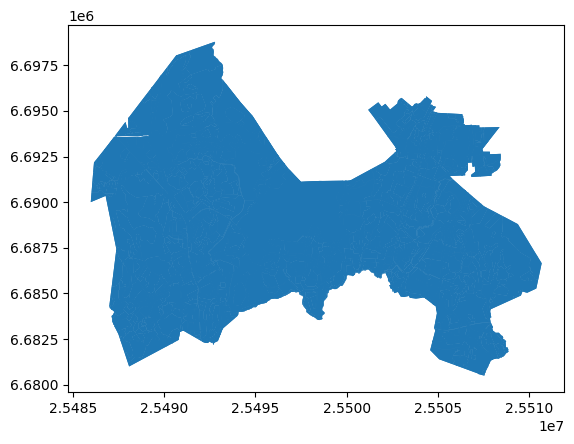

In [94]:
zone.plot()

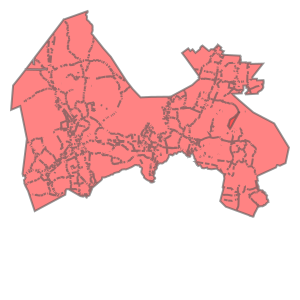

In [95]:
zone.geometry.unary_union

In [96]:
zone_raster = make_geocube(zone, resolution=(-16, 16), measurements=["factor"], output_crs="EPSG:3067")


In [97]:
zone_raster

<xarray.Dataset>
Dimensions:      (y: 1170, x: 1537)
Coordinates:
  * y            (y) float64 6.698e+06 6.698e+06 ... 6.679e+06 6.679e+06
  * x            (x) float64 3.755e+05 3.755e+05 ... 4.001e+05 4.001e+05
    spatial_ref  int64 0
Data variables:
    factor       (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

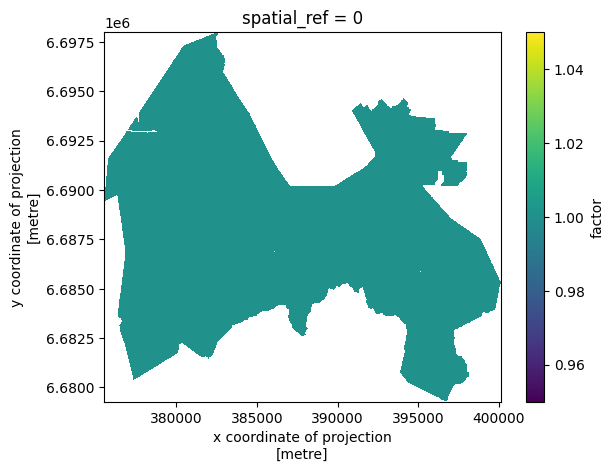

In [98]:
zone_raster["factor"].plot()

In [99]:
carbon_arr = zone_raster["factor"] * carbon

In [100]:
carbon_arr.sum(skipna=True)

<xarray.DataArray ()>
array(57914465.51039997)
Coordinates:
    spatial_ref  int64 0